In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models  

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm, trange
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import confusion_matrix, accuracy_score  
import seaborn as sns


In [31]:
class Config:
    data_dir = "D:\project3\image_dataset\用于训练的所有图片"
    label_csv = "D:\project3\image_dataset\labels.csv"
    img_size = 224
    batch_size = 32
    epochs = 60
    lr = 5e-5  
    num_workers = 0  
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_name = "efficientnet_b0"  
    save_dir = "./output"
    seed = 42

torch.manual_seed(Config.seed)
os.makedirs(Config.save_dir, exist_ok=True)

In [32]:
class TumorDataset(Dataset):
    def __init__(self, df, img_dir, train=True):
        self.df      = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.train   = train
        
        if self.train:
            self.transform = get_transforms(train=True)
        else:
            self.transform = get_transforms(train=False)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row      = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])
        # 1) 读图并转成 numpy
        image = np.array(Image.open(img_path).convert('RGB'))
        # 2) 统一 transform
        image = self.transform(image=image)['image']  # 已经是 Tensor, C×H×W
        # 3) 取标签
        label = int(row['label'])
        return image, label


In [33]:
import torch
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader

def rand_bbox(size, lam):
    """
    CutMix 随机生成一个矩形框。
    size: tuple (W, H)
    lam: 从 Beta 分布中采样的 λ
    返回 (x0, y0, x1, y1)
    """
    W, H = size
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # 随机中心
    cx = random.randint(0, W)
    cy = random.randint(0, H)

    x0 = np.clip(cx - cut_w // 2, 0, W)
    y0 = np.clip(cy - cut_h // 2, 0, H)
    x1 = np.clip(cx + cut_w // 2, 0, W)
    y1 = np.clip(cy + cut_h // 2, 0, H)

    return x0, y0, x1, y1

class MixUpCollator:
    def __init__(self, alpha=0.4, prob=0.5):
        """
        alpha: MixUp Beta 分布参数
        prob: 每个 batch 应用 MixUp 的概率
        """
        self.alpha = alpha
        self.prob  = prob

    def __call__(self, batch):
        # batch: list of (image_tensor, label)
        images, labels = zip(*batch)
        images = torch.stack(images)                          # [B, C, H, W]
        labels = torch.tensor(labels, dtype=torch.float32).view(-1,1)  # [B, 1]

        if np.random.rand() > self.prob:
            return images, labels

        lam = np.random.beta(self.alpha, self.alpha)
        idx = torch.randperm(images.size(0))
        mixed_images = lam * images + (1. - lam) * images[idx]
        mixed_labels = lam * labels + (1. - lam) * labels[idx]
        return mixed_images, mixed_labels

class CutMixCollator:
    def __init__(self, beta=1.0, prob=0.5):
        """
        beta: CutMix Beta 分布参数
        prob: 每个 batch 应用 CutMix 的概率
        """
        self.beta = beta
        self.prob = prob

    def __call__(self, batch):
        images, labels = zip(*batch)
        images = torch.stack(images)                          
        labels = torch.tensor(labels, dtype=torch.float32).view(-1,1)  

        if np.random.rand() > self.prob:
            return images, labels

        lam = np.random.beta(self.beta, self.beta)
        idx = torch.randperm(images.size(0))

        # 随机裁框
        _, C, H, W = images.shape
        x0, y0, x1, y1 = rand_bbox((W, H), lam)

        images_cut = images.clone()
        # 将第 i 张图的 (y0:y1, x0:x1) 区域替换为第 idx[i] 张图同区域
        images_cut[:, :, y0:y1, x0:x1] = images[idx, :, y0:y1, x0:x1]

        # 重新计算 λ：去掉的区域比例
        area = (x1 - x0) * (y1 - y0)
        lam_adj = 1. - area / (W * H)

        mixed_labels = lam_adj * labels + (1. - lam_adj) * labels[idx]
        return images_cut, mixed_labels


In [34]:
import torch
import torch.nn as nn

class CBAM(nn.Module):
    def __init__(self, channel, reduction=16, kernel_size=7):
        super().__init__()
        # 通道注意力
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.mlp = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, bias=False)
        )
        self.sigmoid_channel = nn.Sigmoid()
        # 空间注意力
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        # 通道注意力
        avg_out = self.mlp(self.avg_pool(x))
        max_out = self.mlp(self.max_pool(x))
        x = x * self.sigmoid_channel(avg_out + max_out)
        # 空间注意力
        avg_map = x.mean(dim=1, keepdim=True)
        max_map, _ = x.max(dim=1, keepdim=True)
        x = x * self.sigmoid_spatial(self.conv_spatial(torch.cat([avg_map, max_map], dim=1)))
        return x


In [35]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_transforms(train=True):
    if train:
        return A.Compose([
            # 用 size 参数取代 height & width
            A.RandomResizedCrop(
                size=(Config.img_size, Config.img_size),
                scale=(0.8, 1.0),
                ratio=(0.9, 1.1),
                p=1.0
            ),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.ColorJitter(
                brightness=0.2, contrast=0.2,
                saturation=0.2, hue=0.1, p=0.5
            ),
            A.CoarseDropout(
                max_holes=8, max_height=16, max_width=16,
                min_holes=1, min_height=8, min_width=8, p=0.3
            ),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            # 再保证输出尺寸
            A.Resize(
                height=Config.img_size,
                width=Config.img_size
            ),
            A.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)
            ),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(
                height=Config.img_size,
                width=Config.img_size
            ),
            A.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)
            ),
            ToTensorV2()
        ])



In [36]:
from torchvision import models

class TumorClassifierCBAM(nn.Module):
    def __init__(self, dropout_p=0.7):
        super().__init__()
        # 1) 预训练 EfficientNet-B0，不要它的分类头
        backbone = models.efficientnet_b0(pretrained=True)
        self.features = backbone.features  # [B,1280,H',W']
        
        # 2) 在主干最后插一个 CBAM
        self.cbam = CBAM(channel=1280, reduction=16, kernel_size=7)
        
        # 3) 全局池化
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # 4) 分类头：BatchNorm1d -> Dropout -> Linear
        in_feats = backbone.classifier[1].in_features  # =1280
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(in_feats),
            nn.Dropout(p=dropout_p),
            nn.Linear(in_feats, 1)
        )

    def forward(self, x):
        x = self.features(x)     # [B,1280,H',W']
        x = self.cbam(x)         # 加入注意力机制
        x = self.global_pool(x)  # [B,1280,1,1]
        x = x.flatten(1)         # [B,1280]
        x = self.classifier(x)   # [B,1]
        return x


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """
    二分类 Focal Loss.
    logits: 网络原始输出，shape [B,1] 或 [B]
    targets: 0/1 标签，shape [B,1] 或 [B]
    """
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        # flatten
        if logits.dim()>1:
            logits = logits.view(-1)
        targets = targets.view(-1).float()
        # 1) 先算 BCE
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        probas  = torch.sigmoid(logits)
        # 2) p_t
        p_t = probas * targets + (1 - probas) * (1 - targets)
        # 3) α 平衡因子
        alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        # 4) (1−p_t)^γ
        modulating_factor = (1 - p_t).pow(self.gamma)
        loss = alpha_factor * modulating_factor * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [38]:
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss = 0
    for images, labels in tqdm(loader):
        images = images.to(Config.device)

       
        labels = labels.to(Config.device).float()
        if labels.dim() == 1:
            labels = labels.unsqueeze(1)  # 只在 [B] -> [B,1] 时加这一维

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)        # [B,1]
            loss    = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)


In [39]:
def evaluate(model, loader, criterion):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.inference_mode():
        for images, labels in loader:
            images = images.to(Config.device)
            labels = labels.to(Config.device).float()
            if labels.dim() == 1:
                labels = labels.unsqueeze(1)

            logits = model(images)
            loss   = criterion(logits, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), np.array(all_preds).ravel(), np.array(all_labels).ravel()


In [40]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

In [41]:
from sklearn.model_selection import train_test_split

# 读取 CSV 标签
full_df = pd.read_csv(Config.label_csv)

# 三分法划分 train / val / test
train_df, tmp_df = train_test_split(
    full_df,
    test_size=0.3,
    stratify=full_df['label'],
    random_state=Config.seed
)
val_df, test_df = train_test_split(
    tmp_df,
    test_size=0.5,
    stratify=tmp_df['label'],
    random_state=Config.seed
)

print(f"训练集类别分布：\n{train_df['label'].value_counts()}")
print(f"验证集类别分布：\n{val_df['label'].value_counts()}")
print(f"测试集类别分布：\n{test_df['label'].value_counts()}")

训练集类别分布：
label
0    17028
1     1906
Name: count, dtype: int64
验证集类别分布：
label
0    3649
1     408
Name: count, dtype: int64
测试集类别分布：
label
0    3649
1     409
Name: count, dtype: int64


In [42]:
use_mix_mode = "mixup"  # 可选: "none", "mixup", "cutmix"
if use_mix_mode.lower() == "cutmix":
    collate_fn = CutMixCollator(beta=1.0, prob=0.5)
    shuffle_train = False
elif use_mix_mode.lower() == "mixup":
    collate_fn = MixUpCollator(alpha=0.4, prob=0.5)
    shuffle_train = False
else:
    collate_fn = None
    shuffle_train = True

print(f"Mix mode={use_mix_mode}, shuffle_train={shuffle_train}")

# 构建 Dataset
train_dataset = TumorDataset(train_df, Config.data_dir, train=True)
val_dataset   = TumorDataset(val_df,   Config.data_dir, train=False)
test_dataset  = TumorDataset(test_df,  Config.data_dir, train=False)

# 构建 DataLoader
from torch.utils.data import WeightedRandomSampler

# 在构建 train_loader 之前，加一段计算每个样本权重的代码：
class_counts = train_df['label'].value_counts().to_dict()  
# e.g. {0: 9000, 1: 1000}
weights = train_df['label'].map(lambda x: 1.0 / class_counts[x]).values
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# 然后把 train_loader 改成：
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.batch_size,
    shuffle=False,            # 用 sampler 时不要再 shuffle
    sampler=sampler,
    num_workers=Config.num_workers,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.batch_size,
    shuffle=False,
    num_workers=Config.num_workers
)
test_loader = DataLoader(
    test_dataset,
    batch_size=Config.batch_size,
    shuffle=False,
    num_workers=Config.num_workers
)

# 初始化模型
print("初始化模型中...")
model = TumorClassifierCBAM(dropout_p=0.8).to(Config.device)
print("模型初始化完成")

optimizer = optim.Adam(
    model.parameters(),
    lr=Config.lr,
    weight_decay=5e-4
)
criterion = nn.BCEWithLogitsLoss()
early_stopper = EarlyStopping(patience=5)
scaler = GradScaler()

history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_f1': []}
best_auc = 0
best_thresh = 0.5  # 会在训练中更新

# 显示训练集类别分布
train_labels = train_df['label']
print(f"当前训练集图像分布：正常类 {(train_labels == 0).sum()}，肿瘤类 {(train_labels == 1).sum()}")

Mix mode=mixup, shuffle_train=False
初始化模型中...
模型初始化完成
当前训练集图像分布：正常类 17028，肿瘤类 1906


C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\2951910514.py:20: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width' are not valid for transform CoarseDropout
  A.CoarseDropout(
C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\2951910514.py:24: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
D:\project3\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\project3\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the m

In [43]:
# —— 训练循环：只用 Val AUC 早停，不在每轮中做阈值搜索 —— 

best_auc     = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_auc': []}

for epoch in range(Config.epochs):
    print(f"\n📘 Epoch {epoch+1}/{Config.epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss, preds, targets = evaluate(model, val_loader, criterion)
    val_auc = roc_auc_score(targets, preds)

    # 打印指标（仅用 AUC 评估）
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f}")

    # 记录历史
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)

    # 保存最优模型（按 AUC）
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), os.path.join(Config.save_dir, "best_model.pth"))
        print(" Best model saved.")

    # 早停检查（监控 AUC）
    early_stopper(val_auc)
    if early_stopper.early_stop:
        print(" Early stopping triggered.")
        break

# —— 训练结束后，再做一次整体阈值搜素 & 最终评估 —— 

# 加载最佳模型权重
model.load_state_dict(torch.load(os.path.join(Config.save_dir, "best_model.pth")))
model.eval()

# 在整个验证集上计算概率
_, preds, targets = evaluate(model, val_loader, criterion)
preds = preds.ravel()
targets = targets.ravel()

# 搜索最佳 F1 阈值
best_f1, best_thresh = 0.0, 0.5
for t in np.arange(0.1, 0.9, 0.01):
    f1 = f1_score(targets, (preds >= t).astype(int))
    if f1 > best_f1:
        best_f1, best_thresh = f1, t

# 最终按最佳阈值计算指标
final_preds = (preds >= best_thresh).astype(int)
final_acc  = accuracy_score(targets, final_preds)
final_auc  = roc_auc_score(targets, preds)
tn, fp, fn, tp = confusion_matrix(targets, final_preds).ravel()
final_spec = tn/(tn+fp)
final_sens = tp/(tp+fn)

print("\n=== 最终验证集评估 ===")
print(f"Best F1 Threshold: {best_thresh:.2f}")
print(f"ACC:         {final_acc:.4f}")
print(f"F1-score:    {best_f1:.4f}")
print(f"AUC:         {final_auc:.4f}")
print(f"Specificity: {final_spec:.4f}")
print(f"Sensitivity: {final_sens:.4f}")



📘 Epoch 1/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:47<00:00,  5.51it/s]


Train Loss: 0.6911 | Val Loss: 0.3015 | Val AUC: 0.8830
 Best model saved.

📘 Epoch 2/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:45<00:00,  5.62it/s]


Train Loss: 0.5882 | Val Loss: 0.3174 | Val AUC: 0.9112
 Best model saved.

📘 Epoch 3/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:44<00:00,  5.69it/s]


Train Loss: 0.5316 | Val Loss: 0.2836 | Val AUC: 0.9196
 Best model saved.

📘 Epoch 4/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:58<00:00,  5.00it/s]


Train Loss: 0.4966 | Val Loss: 0.2768 | Val AUC: 0.9284
 Best model saved.

📘 Epoch 5/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:56<00:00,  5.07it/s]


Train Loss: 0.4654 | Val Loss: 0.2537 | Val AUC: 0.9289
 Best model saved.

📘 Epoch 6/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:58<00:00,  4.99it/s]


Train Loss: 0.4447 | Val Loss: 0.2318 | Val AUC: 0.9322
 Best model saved.

📘 Epoch 7/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:59<00:00,  4.97it/s]


Train Loss: 0.4404 | Val Loss: 0.2237 | Val AUC: 0.9318

📘 Epoch 8/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:58<00:00,  4.98it/s]


Train Loss: 0.4169 | Val Loss: 0.2269 | Val AUC: 0.9315

📘 Epoch 9/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:58<00:00,  4.98it/s]


Train Loss: 0.3975 | Val Loss: 0.2381 | Val AUC: 0.9346
 Best model saved.

📘 Epoch 10/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:58<00:00,  5.00it/s]


Train Loss: 0.4014 | Val Loss: 0.2228 | Val AUC: 0.9353
 Best model saved.

📘 Epoch 11/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:58<00:00,  5.00it/s]


Train Loss: 0.3834 | Val Loss: 0.2233 | Val AUC: 0.9341

📘 Epoch 12/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:58<00:00,  5.00it/s]


Train Loss: 0.3759 | Val Loss: 0.2198 | Val AUC: 0.9338

📘 Epoch 13/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:59<00:00,  4.94it/s]


Train Loss: 0.3829 | Val Loss: 0.1989 | Val AUC: 0.9368
 Best model saved.

📘 Epoch 14/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:59<00:00,  4.96it/s]


Train Loss: 0.3647 | Val Loss: 0.2134 | Val AUC: 0.9312

📘 Epoch 15/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:56<00:00,  5.06it/s]


Train Loss: 0.3549 | Val Loss: 0.2227 | Val AUC: 0.9300

📘 Epoch 16/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:57<00:00,  5.04it/s]


Train Loss: 0.3373 | Val Loss: 0.2075 | Val AUC: 0.9244

📘 Epoch 17/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:58<00:00,  4.99it/s]


Train Loss: 0.3336 | Val Loss: 0.2001 | Val AUC: 0.9307

📘 Epoch 18/60


  0%|          | 0/592 [00:00<?, ?it/s]C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\505999576.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 592/592 [01:59<00:00,  4.97it/s]


Train Loss: 0.3472 | Val Loss: 0.2121 | Val AUC: 0.9310
 Early stopping triggered.


C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\3958736942.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(Config.save_


=== 最终验证集评估 ===
Best F1 Threshold: 0.60
ACC:         0.9290
F1-score:    0.6705
AUC:         0.9368
Specificity: 0.9526
Sensitivity: 0.7181


划分校验通过，train/val/test 三个集合互不重叠。


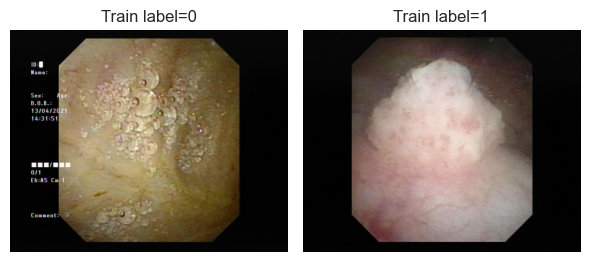

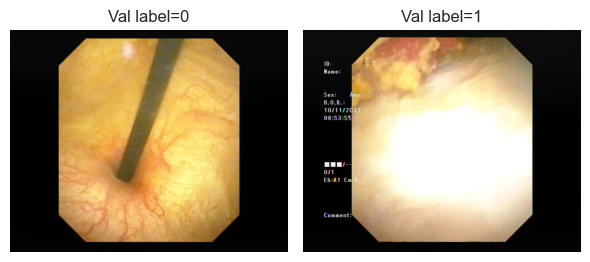

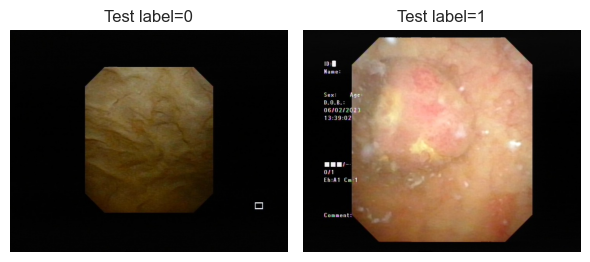

In [44]:
import random
# —— 在三分法划分后加入以下检查 —— 
train_files = set(train_df['filename'].tolist())
val_files   = set(val_df  ['filename'].tolist())
test_files  = set(test_df ['filename'].tolist())

# 检查两两交集是否为空
assert train_files.isdisjoint(val_files),  \
    f"数据泄露：train 与 val 有 {len(train_files & val_files)} 张图重复"
assert train_files.isdisjoint(test_files), \
    f"数据泄露：train 与 test 有 {len(train_files & test_files)} 张图重复"
assert val_files.isdisjoint(test_files),   \
    f"数据泄露：val   与 test 有 {len(val_files & test_files)} 张图重复"

print("划分校验通过，train/val/test 三个集合互不重叠。")

# 手动设置路径和参数
label_csv = r"D:\project3\image_dataset\labels.csv"
img_dir   = r"D:\project3\image_dataset\用于训练的所有图片"
seed = 42

# 1. 读取标签并去重
df = pd.read_csv(label_csv).drop_duplicates(subset=['filename'])

# 2. 三分法划分
train_df, tmp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=seed
)
val_df, test_df = train_test_split(
    tmp_df, test_size=0.5, stratify=tmp_df['label'], random_state=seed
)

# 3. 定义显示函数
def show_samples(df, name):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for ax, label in zip(axes, [0, 1]):
        subset = df[df['label'] == label]
        fname = random.choice(subset['filename'].tolist())
        img = Image.open(os.path.join(img_dir, fname)).convert('RGB')
        ax.imshow(img)
        ax.set_title(f"{name} label={label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 4. 显示三个集合的样本
show_samples(train_df, "Train")
show_samples(val_df, "Val")
show_samples(test_df, "Test")



C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\2980634848.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(Config.save_d

Test Loss: 0.1848 | Test AUC: 0.9535 | Test F1: 0.6651 | Test Acc: 0.9276
Test Sensitivity (Recall for tumor): 0.7139 | Test Specificity (Recall for normal): 0.9515


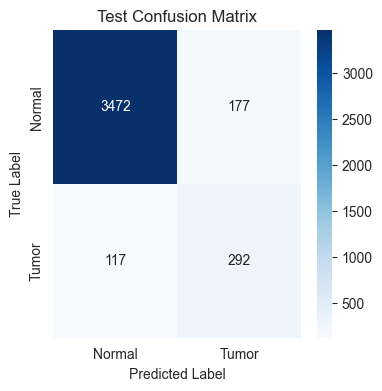

In [45]:
# 加载最佳模型
model.load_state_dict(torch.load(os.path.join(Config.save_dir, "best_model.pth")))
model.eval()

# 在测试集上评估
test_loss, test_preds, test_targets = evaluate(model, test_loader, criterion)
test_auc  = roc_auc_score(test_targets, test_preds)
test_f1   = f1_score(test_targets, (test_preds >= best_thresh).astype(int))
test_acc  = accuracy_score(test_targets, (test_preds >= best_thresh).astype(int))

# 计算混淆矩阵并提取指标
cm = confusion_matrix(test_targets, (test_preds >= best_thresh).astype(int))
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn + 1e-8)  # True Positive Rate
specificity = tn / (tn + fp + 1e-8)  # True Negative Rate

# 打印所有指标
print(f"Test Loss: {test_loss:.4f} | Test AUC: {test_auc:.4f} | "
      f"Test F1: {test_f1:.4f} | Test Acc: {test_acc:.4f}")
print(f"Test Sensitivity (Recall for tumor): {sensitivity:.4f} | "
      f"Test Specificity (Recall for normal): {specificity:.4f}")

# 绘制测试集混淆矩阵
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Tumor"],
            yticklabels=["Normal", "Tumor"])
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 保存测试集预测结果
test_df = test_df.copy()
test_df['pred_prob']  = test_preds
test_df['pred_label'] = (test_preds >= best_thresh).astype(int)
test_df.to_csv(os.path.join(Config.save_dir, "test_predictions.csv"), index=False)


C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\1400981547.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./output/best_model.pth"

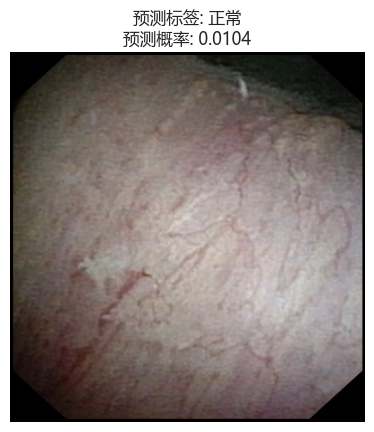

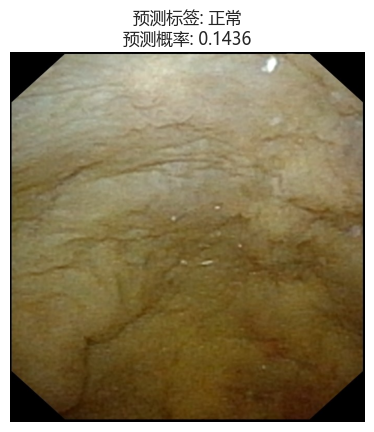

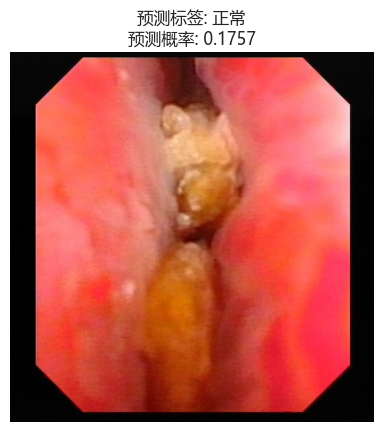

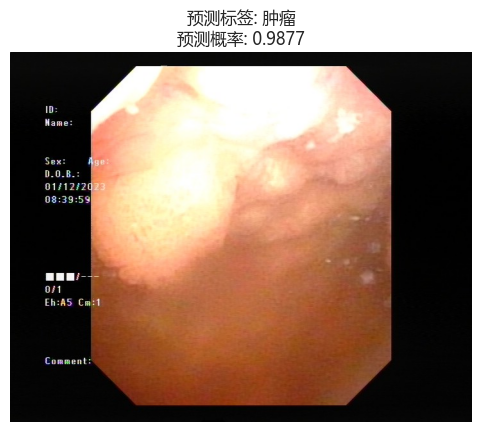

In [46]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import matplotlib


matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号


model.load_state_dict(torch.load("./output/best_model.pth"))
model.eval()


infer_transform = get_transforms(train=False)


def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    
    # Apply transform
    transformed = infer_transform(image=image_np)
    input_tensor = transformed['image'].unsqueeze(0).to(Config.device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        label = 1 if prob >= 0.5 else 0

    # 可视化
    plt.imshow(image_np)
    plt.axis('off')
    plt.title(f"预测标签: {'肿瘤' if label==1 else '正常'}\n预测概率: {prob:.4f}")
    plt.show()


predict_image("D:\project3\dataset\\test_predict_image\\test1.jpg")
predict_image("D:\project3\dataset\\test_predict_image\\test2.jpg")
predict_image("D:\project3\dataset\\test_predict_image\\test3.jpg")
predict_image("D:\project3\dataset\\test_predict_image\\test4.jpg")



External classes: ['normal', 'tumor']
外部验证集: 16006 张图, 251 个 batch


D:\project3\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\project3\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Minder\AppData\Local\Temp\ipykernel_36264\16396214.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURI

Loaded best_model.pth


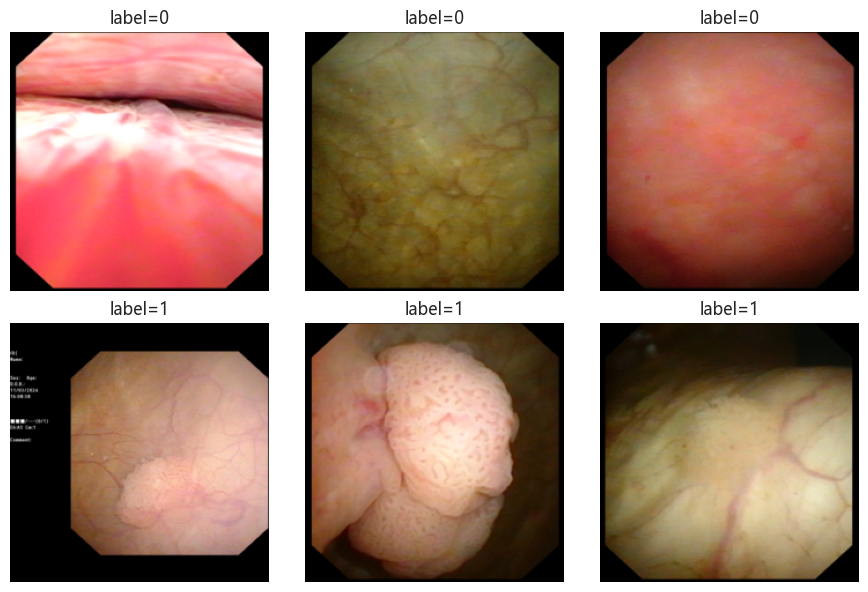

External Inference: 100%|██████████| 251/251 [18:44<00:00,  4.48s/it]


=== 外部验证集评估结果 ===
样本总数: 16006 (normal=14801, tumor=1205)
ACC:         0.9466
F1-score:    0.7057
AUC:         0.9692
Specificity: 0.9545
Sensitivity: 0.8498


In [47]:
# %% [markdown]
# ## 外部验证集评估 — 带去黑边 & 居中补齐预处理

# %%
import os
import torch
import numpy as np
from pathlib import Path
from tqdm import tqdm
from PIL import Image, ImageOps
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score, f1_score,
    roc_auc_score, confusion_matrix
)

# —— 新增：去黑边 + 居中补齐预处理函数 —— 
def preprocess_image(img: Image.Image) -> Image.Image:
    # 1) 转为 numpy 判断哪儿全黑
    arr = np.array(img)
    if arr.ndim == 3:
        mask = np.any(arr != arr[0,0,:], axis=2)
    else:
        mask = arr != arr[0,0]
    coords = np.argwhere(mask)
    if coords.size:
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0)
        img = img.crop((x0, y0, x1 + 1, y1 + 1))
    # 2) 居中 pad 成正方形
    w, h = img.size
    max_wh = max(w, h)
    pad_w = (max_wh - w) // 2
    pad_h = (max_wh - h) // 2
    padding = (pad_w, pad_h, max_wh - w - pad_w, max_wh - h - pad_h)
    img = ImageOps.expand(img, padding, fill=0)
    return img

# 1. 配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ext_root = r"D:\project3\test验证集"
best_model_path = os.path.join(Config.save_dir, "best_model.pth")
batch_size = 64
num_workers = 0

# 2. 预处理（加上 preprocess_image）
ext_transform = transforms.Compose([
    transforms.Lambda(lambda img: preprocess_image(img)),  # ← 新增
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406),
                         std=(0.229,0.224,0.225)),
])

# 3. 构建 DataLoader
ext_dataset = ImageFolder(root=ext_root, transform=ext_transform)
print("External classes:", ext_dataset.classes)
ext_loader = DataLoader(
    ext_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)
print(f"外部验证集: {len(ext_dataset)} 张图, {len(ext_loader)} 个 batch")

# 4. 初始化模型并加载权重
model = TumorClassifierCBAM(dropout_p=0.8).to(Config.device)
state = torch.load(best_model_path, map_location=device)
model.load_state_dict(state)
model.eval()
print("Loaded best_model.pth")
# %% [markdown]
# ## 外部验证集评估 — 展示每个 label 下 3 张经过 transform 的图像

# %%
import matplotlib.pyplot as plt
import random

# 先从 ext_dataset 里各抽 3 张
samples_per_class = {0: [], 1: []}
indices = list(range(len(ext_dataset)))
random.shuffle(indices)
for idx in indices:
    img, label = ext_dataset[idx]  # 已经做了 preprocess + Resize + ToTensor + Normalize
    if len(samples_per_class[label]) < 3:
        samples_per_class[label].append(img)
    if len(samples_per_class[0]) == 3 and len(samples_per_class[1]) == 3:
        break

# 定义一个反归一化，用于可视化
inv_norm = transforms.Normalize(
    mean=[-m/s for m,s in zip((0.485,0.456,0.406),(0.229,0.224,0.225))],
    std=[1/s for s in (0.229,0.224,0.225)]
)

# 绘图
fig, axes = plt.subplots(2, 3, figsize=(9, 6))
for cls, row in samples_per_class.items():
    for i, tensor_img in enumerate(row):
        img_vis = inv_norm(tensor_img)                 # 先反归一化
        img_vis = img_vis.permute(1,2,0).clamp(0,1)    # HWC
        axes[cls, i].imshow(img_vis.numpy())
        axes[cls, i].set_title(f"label={cls}")
        axes[cls, i].axis('off')
plt.tight_layout()
plt.show()

# 5. 推理
all_probs, all_labels = [], []
with torch.inference_mode():
    for imgs, labels in tqdm(ext_loader, desc="External Inference"):
        imgs = imgs.to(device, non_blocking=True)
        logits = model(imgs).view(-1)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(labels.numpy())

all_probs  = np.array(all_probs)
all_labels = np.array(all_labels).astype(int)

# 6. 计算并打印指标
preds = (all_probs >= 0.5).astype(int)
acc  = accuracy_score(all_labels, preds)
f1   = f1_score(all_labels, preds)
auc  = roc_auc_score(all_labels, all_probs)
tn, fp, fn, tp = confusion_matrix(all_labels, preds).ravel()
spec = tn / (tn + fp)
sens = tp / (tp + fn)

print("\n=== 外部验证集评估结果 ===")
print(f"样本总数: {len(ext_dataset)} "
      f"(normal={ext_dataset.targets.count(0)}, tumor={ext_dataset.targets.count(1)})")
print(f"ACC:         {acc:.4f}")
print(f"F1-score:    {f1:.4f}")
print(f"AUC:         {auc:.4f}")
print(f"Specificity: {spec:.4f}")
print(f"Sensitivity: {sens:.4f}")
